# One-Dimensional Second Order Lagrange Elements  

Solves the Poisson equation $- \frac{d^2 \, u(x)}{dx^2} = f(x)$ on the unit bar domain $x \in \Omega=(0,1)$ supplied with various boundary conditions and various source terms. The Galerkin finite element method with second order Lagrangian elements is employed.  

## To do 

1. extend documentation: what is Emast, Xi, Xis, Phi, dPhi?
2. extend to include saturation. Include 1/mu(normB2). 

## Import Packages

In [1]:
using LinearAlgebra
using FastGaussQuadrature
using Plots
using SparseArrays
using BenchmarkTools 
using Test

## Section 1/: Introduction  
The <b>goals</b> of this notebook are two-fold. The first goal is to to extend previously developed notebooks from linear to quadratic notebook. The second goal is to introduce quadrature in the assembly process. 

## Section 2:/ Verification using First Order Basis Functions

In [6]:
# polynomial degree to FE approximation  
pdegree = 1;
# degree of numerical quadrature 
qorder = 4; 
xi, w = gausslegendre(qorder) 

([-0.8611363115940526, -0.3399810435848563, 0.3399810435848563, 0.8611363115940526], [0.34785484513745385, 0.6521451548625462, 0.6521451548625462, 0.34785484513745385])

In [7]:
# coordinates of single finite element 
x1 = 0; x2 = 2;
x1 = 0.5; x2 = 1;
x = [x1; x2];  
X = [x1^j for x1 in x, j=pdegree:-1:0] # X is the Vandermonde matrix constructed from x 
I = [1. 0; 0 1.]; 
Emat = X\I

2×2 Matrix{Float64}:
 -2.0   2.0
  2.0  -1.0

In [13]:
# vector of quadrature points on the physical element 
xs = .5*(x2-x1)*xi.+(x1+x2)/2;
# Vandermonde Matrix for evaluation of the basis functions
Xs = zeros(length(w),pdegree+1);   
Xs  = [xs1^p for xs1 in xs, p=pdegree:-1:0];
# Vandermonde Matrix for evaluation of the derivaties of basis functions
dXs = zeros(length(w),pdegree+1);    
dXs[:,1:pdegree] = [p*xs1^(p-1) for xs1 in xs, p=pdegree:-1:1];

In [14]:
# column basis and derivative of the basis vectors  
Phi  = Xs*Emat; 
dPhi = dXs*Emat; 

In [15]:
# test on the local stiffness matrix 
dPhidPhi = zeros(length(w),(pdegree+1)^2);
[dPhidPhi[:,(j-1)*(pdegree+1)+i] = dPhi[:,i].*dPhi[:,j] for i=1:(pdegree+1),j=1:(pdegree+1)];
Aloc = (x2-x1)/2*Transpose(w)*dPhidPhi
@test Aloc == 1/(x2-x1)*[1 -1 -1 1]

Test Passed

In [16]:
# test on the local mass matrix 
PhiPhi = zeros(length(w),(pdegree+1)^2);
[PhiPhi[:,(j-1)*(pdegree+1)+i] = Phi[:,i].*Phi[:,j] for i=1:(pdegree+1),j=1:(pdegree+1)];
Mloc = (x2-x1)/2*Transpose(w)*PhiPhi
display(Mloc)
@test Mloc ≈ (x2-x1)*[1.0/3. 1.0/6. 1.0/6. 1.0/3.]

1×4 transpose(::Vector{Float64}) with eltype Float64:
 0.166667  0.0833333  0.0833333  0.166667

Test Passed

## Section 3:/ Settings used Further in this Notebook  

### Section 1.3:/ Define Degree of FE Approximation and Order of Quadrature 
Note that the reference element is $[-1,1]$ and *not* $[0,1]$. Here the use matrix comprehension to construction a matrix from a vector.

In [18]:
# polynomial degree to FE approximation  
pdegree = 2;
# degree of numerical quadrature 
qorder = 4; 
xi, w = gausslegendre(qorder) 

([-0.8611363115940526, -0.3399810435848563, 0.3399810435848563, 0.8611363115940526], [0.34785484513745385, 0.6521451548625462, 0.6521451548625462, 0.34785484513745385])

### Section 2.3:/ Define Source Function  

In [19]:
function sourceFct(x)
    return x*x 
end 

sourceFct (generic function with 1 method)

## Section 4/: Construction of the Basis Functions for pdegree=2

### Section 1.4/: Compute Coefficients Defining Polynomial Basis Function on Physical Element  

In [20]:
# x1, x2 and x3 are the nodes on the physical element  
# x1 = 0.; x3 = 1.; x2 = (x1+x3)/2;
x1 = -1.; x3 = 1.; x2 = (x1+x3)/2;
x = [x1; x2; x3];  
X = [x1^j for x1 in x, j=pdegree:-1:0] # X is the Vandermonde matrix constructed from x 
I = [1. 0 0; 0 1. 0; 0 0 1.]; 
Emat = X\I

3×3 Matrix{Float64}:
  0.5  -1.0  0.5
 -0.5   0.0  0.5
  0.0   1.0  0.0

In [28]:
# vector of quadrature points on the finite element 
xs = .5*(x3-x1)*xi.+(x1+x3)/2;
# Vandermonde Matrix for evaluation of the basis functions
Xs = zeros(length(w),pdegree+1);   
Xs  = [xs1^p for xs1 in xs, p=pdegree:-1:0];
# Vandermonde Matrix for evaluation of the derivaties of basis functions
dXs = zeros(length(w),pdegree+1);    
dXs[:,1:pdegree] = [p*xs1^(p-1) for xs1 in xs, p=pdegree:-1:1];
display(xs)

4-element Vector{Float64}:
 -0.8611363115940526
 -0.3399810435848563
  0.3399810435848563
  0.8611363115940526

### Section 2.4:/ Check on Computations performed

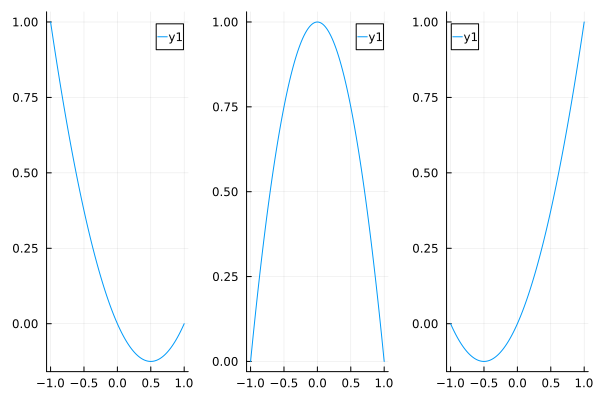

In [29]:
function plotBasisFcts(x1,x3,Emat)
    xvec = [x1:(x3-x1)/100:x3]
    a1, b1, c1 = Emat[:,1]; a2, b2, c2 = Emat[:,2]; a3, b3, c3 = Emat[:,3];  
    phi1(s) = a1*s.*s .+ b1*s .+ c1; y1 = phi1.(xvec); p1 = plot(xvec,y1)
    phi2(s) = a2*s.*s .+ b2*s .+ c2; y2 = phi2.(xvec); p2 = plot(xvec,y2)
    phi3(s) = a3*s.*s .+ b3*s .+ c3; y3 = phi3.(xvec); p3 = plot(xvec,y3)
    plot(p1,p2,p3,layout=(1,3))
end 
plotBasisFcts(x1,x3,Emat)

### Section 3.4/: Basis Functions and First Derivatives in the Quadrature Points 
The matrix Phi (dPhi) is a matrix of size qorder by (porder+1) of which each column is formed by evaluating the (derivative of the) basis function in the quadrature points.   

In [30]:
Phi  = Xs*Emat; 
dPhi = dXs*Emat; 
display(Phi)
display(dPhi)

4×3 Matrix{Float64}:
  0.801346   0.258444  -0.0597903
  0.227784   0.884413  -0.112197
 -0.112197   0.884413   0.227784
 -0.0597903  0.258444   0.801346

4×3 Matrix{Float64}:
 -1.36114    1.72227   -0.361136
 -0.839981   0.679962   0.160019
 -0.160019  -0.679962   0.839981
  0.361136  -1.72227    1.36114

### Section 4.4/: Compute Integrals of (Functions of) the Basis Functions  

In [31]:
(x3-x1)/2*Transpose(w)*Phi # evaluate basis functions over the reference element 

1×3 transpose(::Vector{Float64}) with eltype Float64:
 0.333333  1.33333  0.333333

## Section 5:/ Construction of the Local Vector  

In [32]:
(x3-x1)/2*Transpose(w)*sourceFct.(Xs*Emat)

1×3 transpose(::Vector{Float64}) with eltype Float64:
 0.266667  1.06667  0.266667

## Section 6:/ Construction of the Local Stiffness Matrix  

In [38]:
dPhidP hi = zeros(length(w),(pdegree+1)^2);
[dPhidPhi[:,(j-1)*(pdegree+1)+i] = dPhi[:,i].*dPhi[:,j] for i=1:(pdegree+1),j=1:(pdegree+1)];
Aloc = (x3-x1)/2*Transpose(w)*dPhidPhi
Bloc = reshape(3*(x3-x1)*Aloc,3,3)
display(Bloc)
@test Aloc ≈ 1/(x3-x1)*[7 -8 1 -8 16 -8 1 -8 7]/3

3×3 reshape(transpose(::Vector{Float64}), 3, 3) with eltype Float64:
  7.0  -8.0   1.0
 -8.0  16.0  -8.0
  1.0  -8.0   7.0

Test Passed

## Section 7:/ Construction of the Local Mass Matrix 

In [42]:
PhiPhi = zeros(length(w),(pdegree+1)^2);
[PhiPhi[:,(j-1)*(pdegree+1)+i] = Phi[:,i].*Phi[:,j] for i=1:(pdegree+1),j=1:(pdegree+1)];
Mloc = (x3-x1)/2*Transpose(w)*PhiPhi
Bloc = reshape(30*Mloc,3,3)
display(Bloc)
@test  Mloc ≈ (x3-x1)*[4 2 -1 2 16 2 -1 2 4]/30 

3×3 reshape(transpose(::Vector{Float64}), 3, 3) with eltype Float64:
  8.0   4.0  -2.0
  4.0  32.0   4.0
 -2.0   4.0   8.0

Test Passed

## Section 8:/ Assembly to Global Matrices and Vectors 

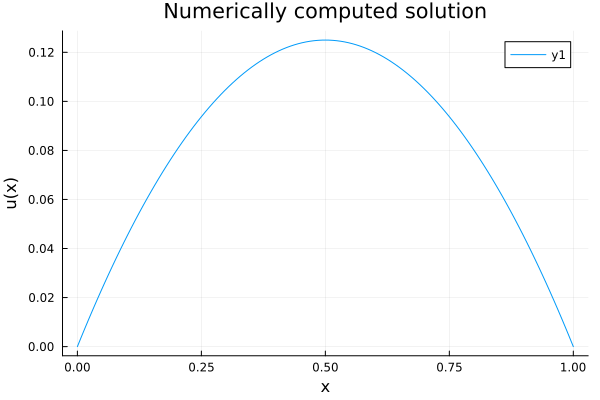

In [48]:
#..construct the mesh: see before 
N = 64; Np1 = N+1; h = 1/N; NN = 2*N+1; 
x = Vector(0:h:1) 

#..Mesh with points and edges 
#..point holds the coordinates of the left and right node of the element
#..edges holds the global indices of the left and right node of the element
points = collect( [x[i], x[i+1]] for i in 1:N) 
edges = collect( [2*i-1, 2*i, 2*i+1] for i in 1:N) 

#..Set the source function 
fsource(x) = x

#..Initialize global matrix and right-hand side value 
floc = zeros(Float64,3,1)
Aloc = zeros(Float64,3,3)
A = zeros(Float64,NN,NN)
f = zeros(Float64,NN,1)

#..Perform loop over elements and assemble vector 
for i=1:N 

  x1, x3 = points[i,:][1]
  x2 = (x1+x3)/2;
  x  = [x1; x2; x3];  
  X  = [x1^j for x1 in x, j=pdegree:-1:0] # X is the Vandermonde matrix constructed from x 
  I = [1. 0 0; 0 1. 0; 0 0 1.]; 
  Emat = X\I;
    
  # vector of quadrature points on the finite element 
  xs = .5*(x3-x1)*xi.+(x1+x3)/2;
  # Vandermonde Matrix for evaluation of the basis functions
  Xs = zeros(length(w),pdegree+1);   
  Xs  = [xs1^p for xs1 in xs, p=pdegree:-1:0];

  Phi  = Xs*Emat; 
    
  floc = Transpose((x3-x1)/2*Transpose(w)*fsource.(Phi)) 

  f[edges[i]] += floc

end

#display(f)

#..Perform loop over elements and assemble matrix 
for i=1:N 

  x1, x3 = points[i,:][1]
  x2 = (x1+x3)/2;
  x  = [x1; x2; x3];  
  X  = [x1^j for x1 in x, j=pdegree:-1:0] # X is the Vandermonde matrix constructed from x 
  I = [1. 0 0; 0 1. 0; 0 0 1.]; 
  Emat = X\I;

  # vector of quadrature points on the finite element  
  xs = .5*(x3-x1)*xi.+(x1+x3)/2;
  # Vandermonde Matrix for evaluation of the derivaties of basis functions
  dXs = zeros(length(w),pdegree+1);    
  dXs[:,1:pdegree] = [p*xs1^(p-1) for xs1 in xs, p=pdegree:-1:1];

  dPhi = dXs*Emat; 
    
  dPhidPhi = zeros(length(w),(pdegree+1)^2);
  [dPhidPhi[:,(j-1)*(pdegree+1)+i] = dPhi[:,i].*dPhi[:,j] for i=1:(pdegree+1),j=1:(pdegree+1)];
    
  Aloc = reshape(.5*(x3-x1)*Transpose(w)*dPhidPhi,3,3) 

  A[edges[i],edges[i]] += Aloc 

end

#..handle the boundary conditions in the matrix and right-hand side vector 
A[1,1] = 1;       A[1,2] = 0;        A[1,3] = 0;      f[1]   = 0
A[end,end-2] = 0; A[end,end-1] = 0;  A[end,end] = 1;  f[end] = 0

#display(A)

#..solve the linear system
u = A \ f

#..plot the solution 
xx = Vector(0:h/2:1) 
p1=plot(xx,u)
xlabel!("x") 
ylabel!("u(x)")
title!("Numerically computed solution")